In [1]:
import torchvision, torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchcp.classification.scores import THR, APS, SAPS, RAPS
from torchcp.classification.predictors import SplitPredictor, ClusterPredictor, ClassWisePredictor
from torchvision.models import resnet50, ResNet50_Weights
import pandas as pd
import seaborn as sns


# 设置随机种子
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  
np.random.seed(seed)

In [2]:
# CIFAR-10 数据集预处理
transform_cifar10 = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# 加载 CIFAR-10 数据集
cifar10_trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_cifar10)
cifar10_testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_cifar10)
cifar10_trainloader = DataLoader(cifar10_trainset, batch_size=16, shuffle=True, num_workers=2)
cifar10_testloader = DataLoader(cifar10_testset, batch_size=16, shuffle=False, num_workers=2)

# MNIST 数据集预处理
transform_mnist = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.Grayscale(num_output_channels=3),  # 将图像从1个通道转换为3个通道
    transforms.ToTensor(),
    transforms.Normalize((0.1307, 0.1307, 0.1307), (0.3081, 0.3081, 0.3081))  # 对每个通道进行标准化
])

# 加载 MNIST 数据集
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform_mnist)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform_mnist)
mnist_trainloader = DataLoader(mnist_trainset, batch_size=16, shuffle=True, num_workers=2)
mnist_testloader = DataLoader(mnist_testset, batch_size=16, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 9912422/9912422 [00:03<00:00, 3130501.25it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 27381485.95it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:01<00:00, 883339.88it/s] 


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 9050132.43it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [3]:
# 加载模型
model = resnet50(weights=ResNet50_Weights.DEFAULT)
if torch.cuda.is_available():
    model = model.cuda()

model.eval()

# 定义共形预测算法
score_functions = [THR(), APS(), SAPS(weight=0.8), RAPS(penalty=0.8)]
predictors = [SplitPredictor, ClusterPredictor, ClassWisePredictor]


alphas = [0.1, 0.3, 0.5]  # example significance levels: 90%, 80%, 70%

# Initialize a dictionary to hold all results
results = {alpha: [] for alpha in alphas}

# Test conformal prediction algorithms and evaluate model performance
for alpha in alphas:
    # CIFAR-10 dataset
    for score_function in score_functions:
        for PredictorClass in predictors:
            predictor_cifar = PredictorClass(score_function=score_function, model=model)
            predictor_cifar.calibrate(cifar10_trainloader, alpha=alpha)  # Calibrate the predictor
            cifar_result = predictor_cifar.evaluate(cifar10_testloader)  # Evaluate on CIFAR-10 test set
            results[alpha].append({
                'Score Function': type(score_function).__name__,
                'Predictor': PredictorClass.__name__,
                'Dataset': 'CIFAR-10',
                'Coverage Rate': cifar_result["Coverage_rate"],
                'Average Set Size': cifar_result["Average_size"]
            })

    # MNIST dataset
    for score_function in score_functions:
        for PredictorClass in predictors:
            predictor_mnist = PredictorClass(score_function=score_function, model=model)
            predictor_mnist.calibrate(mnist_trainloader, alpha=alpha)  # Calibrate the predictor
            mnist_result = predictor_mnist.evaluate(mnist_testloader)  # Evaluate on MNIST test set
            results[alpha].append({
                'Score Function': type(score_function).__name__,
                'Predictor': PredictorClass.__name__,
                'Dataset': 'MNIST',
                'Coverage Rate': mnist_result["Coverage_rate"],
                'Average Set Size': mnist_result["Average_size"]
            })

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:15<00:00, 6.66MB/s]
/root/miniconda3/lib/python3.10/site-packages/torchcp/classification/predictors/split.py:61: UserWarning: The number of scores is 0, which is a invalid scores. To avoid program crash, the threshold is set as torch.inf.
  warnings.warn(


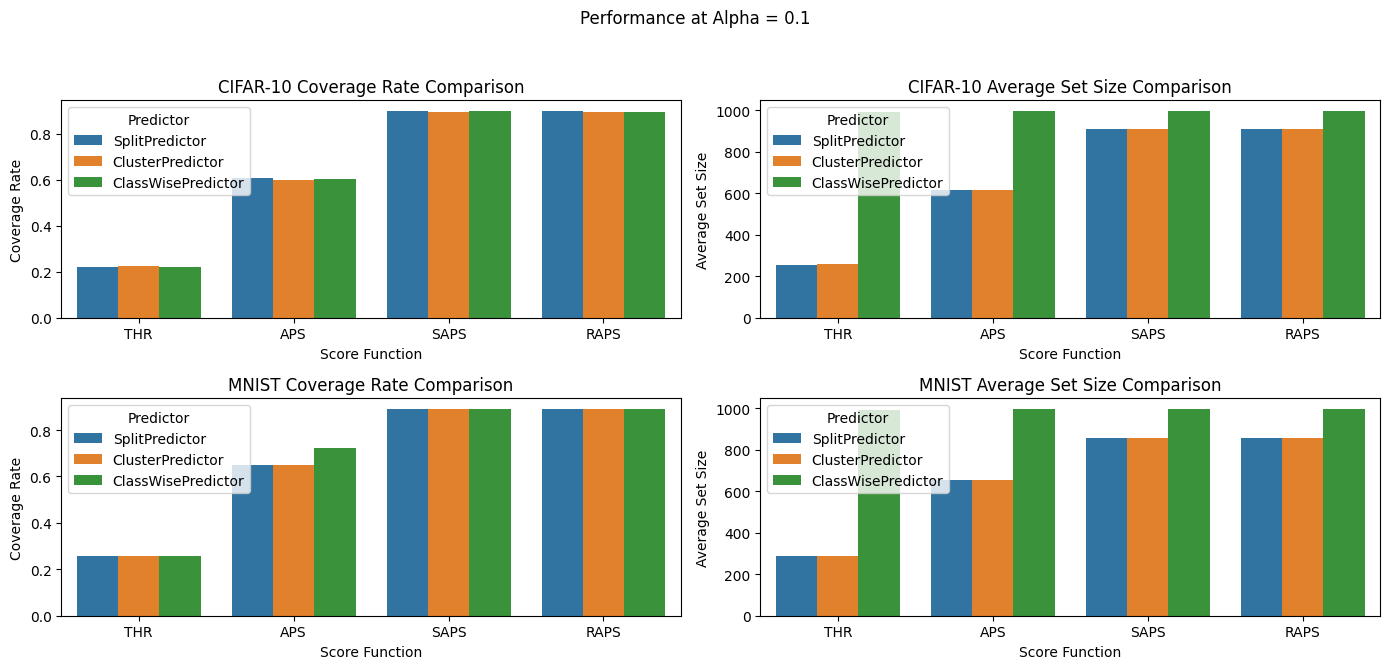

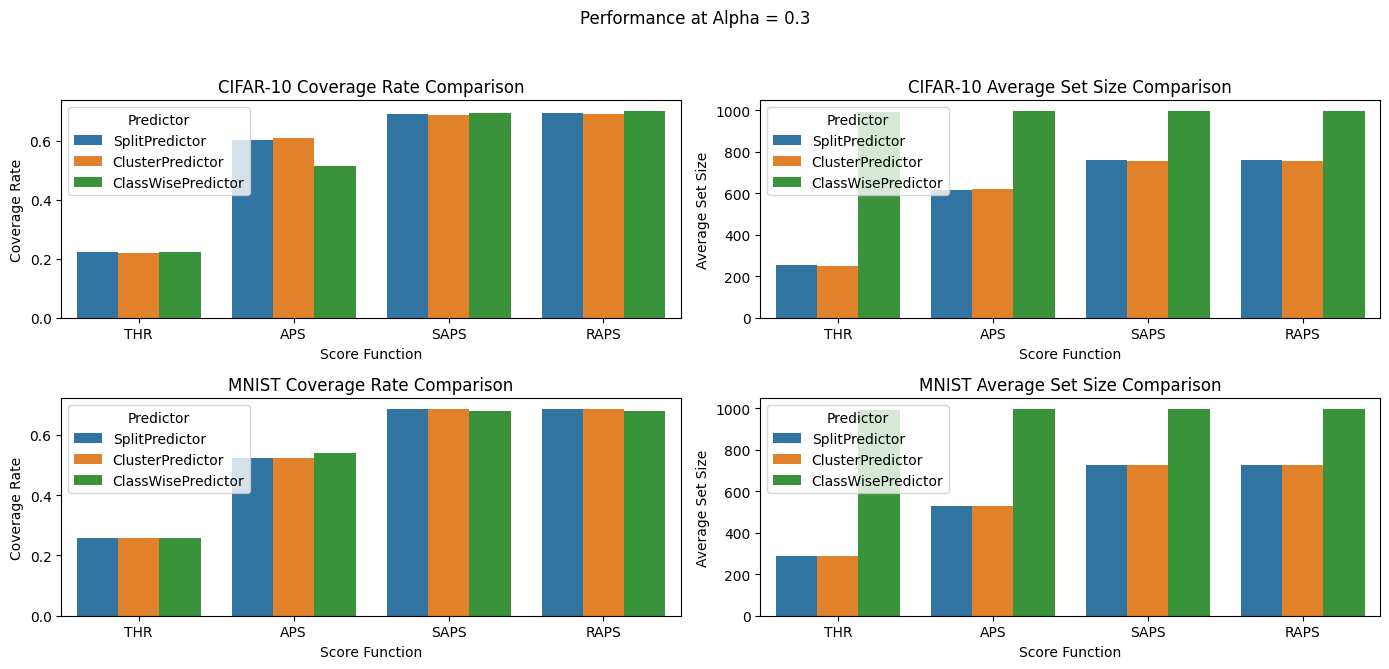

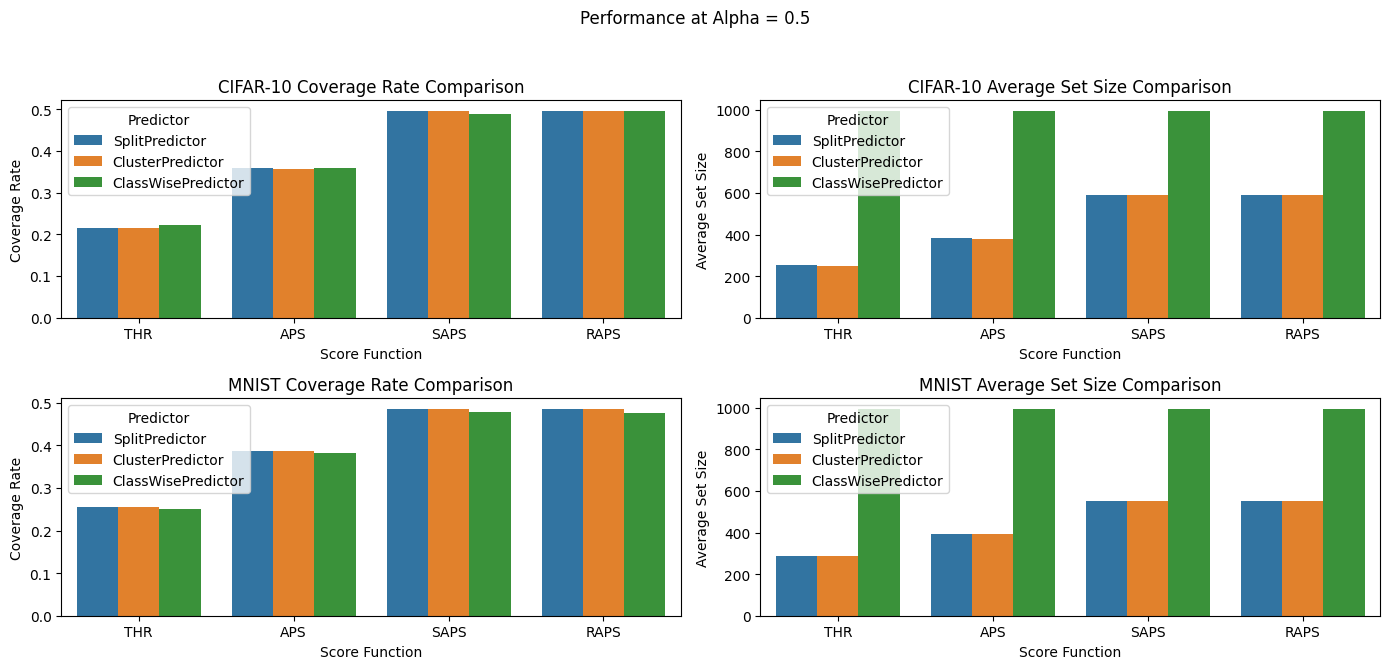

In [4]:

df_results = pd.concat({k: pd.DataFrame(v) for k, v in results.items()}, names=['Alpha', 'Index']).reset_index(level=0)

# Now, let's visualize the results for each alpha
for alpha in alphas:
    df_alpha_cifar = df_results[(df_results['Dataset'] == 'CIFAR-10') & (df_results['Alpha'] == alpha)]
    df_alpha_mnist = df_results[(df_results['Dataset'] == 'MNIST') & (df_results['Alpha'] == alpha)]

    plt.figure(figsize=(14, 7))
    plt.suptitle(f'Performance at Alpha = {alpha}')
    
    plt.subplot(2, 2, 1)
    sns.barplot(x='Score Function', y='Coverage Rate', hue='Predictor', data=df_alpha_cifar)
    plt.title('CIFAR-10 Coverage Rate Comparison')
    
    plt.subplot(2, 2, 2)
    sns.barplot(x='Score Function', y='Average Set Size', hue='Predictor', data=df_alpha_cifar)
    plt.title('CIFAR-10 Average Set Size Comparison')
    
    plt.subplot(2, 2, 3)
    sns.barplot(x='Score Function', y='Coverage Rate', hue='Predictor', data=df_alpha_mnist)
    plt.title('MNIST Coverage Rate Comparison')
    
    plt.subplot(2, 2, 4)
    sns.barplot(x='Score Function', y='Average Set Size', hue='Predictor', data=df_alpha_mnist)
    plt.title('MNIST Average Set Size Comparison')
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


In [5]:
import pandas as pd

# Flatten the nested dictionary structure into a list of dictionaries
flat_results = []
for alpha, entries in results.items():
    for entry in entries:
        # Add the alpha value to each entry
        entry['Alpha'] = alpha
        flat_results.append(entry)

# Create a DataFrame from the flat list of dictionaries
df_results = pd.DataFrame(flat_results)

# Display the DataFrame
df_results[0:24]

,Score Function,Predictor,Dataset,Coverage Rate,Average Set Size,Alpha
0,THR,SplitPredictor,CIFAR-10,0.2202,255.2529,0.1
1,THR,ClusterPredictor,CIFAR-10,0.2231,257.8613,0.1
2,THR,ClassWisePredictor,CIFAR-10,0.2214,992.3542,0.1
3,APS,SplitPredictor,CIFAR-10,0.6091,618.6924,0.1
4,APS,ClusterPredictor,CIFAR-10,0.6012,614.3788,0.1
5,APS,ClassWisePredictor,CIFAR-10,0.6052,996.1315,0.1
6,SAPS,SplitPredictor,CIFAR-10,0.8994,909.4550,0.1
7,SAPS,ClusterPredictor,CIFAR-10,0.8957,910.2623,0.1
8,SAPS,ClassWisePredictor,CIFAR-10,0.8986,999.0492,0.1
9,RAPS,SplitPredictor,CIFAR-10,0.9009,910.0845,0.1
